## 1. 导入依赖包

In [291]:
"""
为什么使用MinMaxScaler而不是StandardScaler？
1. 防止数据不平衡：使用MinMaxScaler可以缩放数据，使其不会因某些特征的值过大而影响模型的结果。
2. 简单易用，并且可以适用于多种数据类型，如数值和类别型数据。（类别型数据怎么缩放？）
3. 可解释性高：MinMaxScaler可以很好地保留数据的原始分布
4. 适用于不同类型的模型：适用于许多不同类型的机器学习模型，并且对于不同类型的模型可以产生不同的结果。（这点不明白）
其他方法简介：
StandardScaler：标准化数据，将数据缩放至均值为 0，方差为 1 的范围内。
RobustScaler：使用中位数和四分位数缩放数据，抗异常值的影响。
Normalizer：把数据的每个样本的模长归一化为 1，可用于处理高维稠密数据。
"""
# 用于划分测试集/数据集
from sklearn.model_selection import train_test_split

# 机器学习框架
import tensorflow as tf
from keras.applications.densenet import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
# TensorFlow和Keras提供了多种方法来保存和加载模型，tf.keras.callbacks.ModelCheckpoint是TensorFlow中的高级保存模型的方法，专门用于Keras API中训练的模型。
# 它提供了一个简单易用的API，用于在每个训练时期保存模型，并可以通过设置权重文件的命名方式，以自定义保存的频率和位置。


# 数据结构处理
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 数据分析与评价
import math
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from keras.regularizers import l2
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

代码变量备注：
df:                 data.csv的原始数据 -> 降维后的数据 -> 处理异常值
df1, df2, df_temp:  临时Dataframe变量，用于预处理数据
all_min:            df填补缺失min值后的全时间序列数据
data:               仅包含date_time和WATCH_UCNT的all_min
train_data, test_data:  使用标准化的data创建的训练集/测试集
X_train, y_train:   使用create_dataset()创建的三维ndarray, [number of samples, time_step I set before, features(WATCH_CNT)]
X_test, y_test:     使用create_dataset()创建的三维ndarray, [number of samples, time_step I set before, features(WATCH_CNT)]
train_predict:      使用模型预测的训练集并inverse_transform
test_predict:       使用模型预测的测试集并inverse_transform
yt->dt:                 用于与test_predict比较的y_test逆标准化序列->Dataframe
pred_data:          预处理后的预测集（加上了最后十分钟的空值），已标准化



## 2. 数据预处理，导入CSV数据

### 2.1 数据导入与参数降维

In [45]:
df = pd.read_csv('../LSTM_DATA/data.csv')
df1 = df['natural_flow_trend_index'].apply(eval).apply(pd.Series)
df2 = df['pay_flow_trend_index'].apply(eval).apply(pd.Series)
df = df.join(df1).join(df2).drop(['natural_flow_trend_index', 'pay_flow_trend_index'], axis = 1)
df.date_time = df.date_time.astype('datetime64[ns]')
df.fillna(0)
df.drop('Unnamed: 0', axis=1)

,UV_VALUE,COMMENT_CNT,date_time,INCR_FANS_CNT,LEAVE_UCNT,FANS_CLUB_UCNT,PAY_ORDER_GMV,ONLINE_USER_CNT,WATCH_UCNT,PAY_CNT,...,头条西瓜,活动页,全部自然流量,关注,千川PC版,其他广告,千川品牌广告,全部付费流量,品牌广告,小店随心推
0,0.0,146,2019-12-03 08:14:00,2.0,11.0,1.0,0.0,47,18.0,0.0,...,0,0,23,7,0,0,0,0,0,0
1,0.0,59,2019-12-03 08:13:00,0.0,19.0,0.0,0.0,39,24.0,0.0,...,1,0,17,6,0,0,0,0,0,0
2,0.0,18,2019-12-03 08:16:00,1.0,10.0,0.0,0.0,56,14.0,0.0,...,0,0,20,11,0,0,0,0,0,0
3,0.0,159,2019-12-03 08:15:00,0.0,8.0,0.0,0.0,52,16.0,0.0,...,1,0,19,4,0,0,0,0,0,0
4,0.0,39,2019-12-03 08:10:00,0.0,16.0,0.0,0.0,29,18.0,0.0,...,0,0,10,5,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38088,0.0,0,2019-10-04 22:38:00,0.0,4.0,0.0,0.0,1,6.0,0.0,...,0,0,3,1,0,0,0,0,0,0
38089,0.0,0,2019-10-04 22:37:00,0.0,1.0,0.0,0.0,1,1.0,0.0,...,0,0,3,0,0,0,0,0,0,0
38090,0.0,0,2019-10-04 22:36:00,1.0,7.0,0.0,0.0,1,7.0,0.0,...,0,0,4,0,0,0,0,0,0,0
38091,0.0,0,2019-10-04 22:35:00,0.0,2.0,0.0,0.0,3,2.0,0.0,...,0,0,3,1,0,0,0,0,0,0


### 2.2 删除极端/单一数据

In [46]:
df_temp = df.groupby(df['date_time'].dt.date).sum()
extreme_situation = []
for i, d in df_temp.iterrows():
    if d['全部自然流量'] + d['全部付费流量'] < 10:
        extreme_situation.append(i)
for e in extreme_situation:
    idx = df[df['date_time'].dt.date == e].index
    df.drop(index=idx, axis=0, inplace=True)

### 2.3 补全时间序列中的缺失项

In [55]:
start_time = df['date_time'].min()
end_time = df['date_time'].max()
helper = pd.DataFrame({'date_time': pd.date_range(start_time, end_time, freq="MIN")})
all_min = pd.merge(df, helper, on='date_time', how="outer").sort_values('date_time')
all_min.fillna(0, inplace=True)
all_min.drop('Unnamed: 0', axis=1, inplace=True)
all_min.to_csv('../LSTM_DATA/all_minutes_data.csv')

In [56]:
all_min

,UV_VALUE,COMMENT_CNT,date_time,INCR_FANS_CNT,LEAVE_UCNT,FANS_CLUB_UCNT,PAY_ORDER_GMV,ONLINE_USER_CNT,WATCH_UCNT,PAY_CNT,...,头条西瓜,活动页,全部自然流量,关注,千川PC版,其他广告,千川品牌广告,全部付费流量,品牌广告,小店随心推
31280,0.0,0.0,2019-10-04 08:00:00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31281,0.0,5.0,2019-10-04 08:01:00,0.0,3.0,0.0,0.0,7.0,9.0,0.0,...,0.0,0.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
31284,0.0,2.0,2019-10-04 08:02:00,2.0,17.0,1.0,0.0,10.0,20.0,0.0,...,0.0,0.0,9.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
31285,0.0,2.0,2019-10-04 08:03:00,0.0,20.0,0.0,0.0,12.0,19.0,0.0,...,1.0,0.0,17.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
31282,0.0,6.0,2019-10-04 08:04:00,0.0,9.0,0.0,0.0,14.0,16.0,0.0,...,0.0,0.0,13.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44,0.0,2.0,2019-12-03 11:52:00,0.0,8.0,0.0,0.0,51.0,13.0,0.0,...,0.0,0.0,6.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
45,0.0,5.0,2019-12-03 11:53:00,0.0,14.0,1.0,0.0,56.0,16.0,0.0,...,0.0,0.0,18.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0
46,0.0,2.0,2019-12-03 11:54:00,0.0,26.0,0.0,0.0,57.0,9.0,0.0,...,0.0,0.0,18.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0
47,0.0,1.0,2019-12-03 11:55:00,0.0,16.0,0.0,0.0,37.0,15.0,0.0,...,0.0,0.0,17.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3. 数据可视化

### 3.1 时间与每分钟新增观看人数的关系

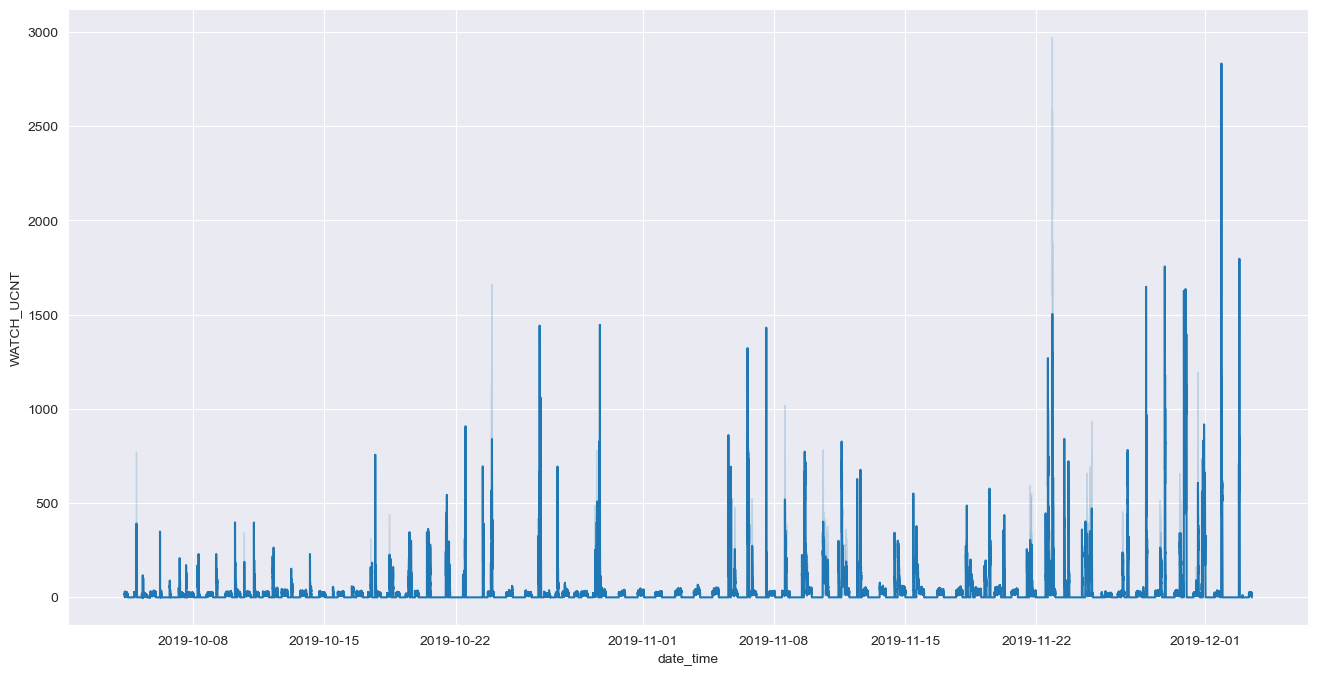

In [57]:
plt.figure(figsize=(16,8))
sns.lineplot(x='date_time', y='WATCH_UCNT', data=all_min)
# 之前一直纳闷sns和matplotlib的关系：Seaborn提供了对Matplotlib的高级接口，是一个基于Matplotlib的库，用于创建统计图形和可视化。
plt.show()

### 3.2 直播时段（上午/中午/晚上）的直播与UV价值的关系

In [58]:
plt.figure(figsize=(16,8))
time_UV = all_min[['UV_VALUE', 'date_time']]
time_UV.loc[:, 'time_category'] = 'null'

for i, row in time_UV.iterrows():
    if bool(len(pd.bdate_range(row['date_time'], row['date_time']))):
        if 2 < row['date_time'].hour < 9:
            row['time_category'] = 'routine'
        elif 9 < row['date_time'].hour < 12:
            row['time_category'] = 'workday_mornings'
        elif 12 < row['date_time'].hour < 14:
            row['time_category'] = 'workday_noon_breaks'
        elif 12 < row['date_time'].hour < 14:
            row['time_category'] = 'workday_afternoons'
        else:
            row['time_category'] = 'workday_nights'
    else:
        if 9 < row['date_time'].hour < 12:
            row['time_category'] = 'weekend mornings'
        elif 12 < row['date_time'].hour < 18:
            row['time_category'] = 'weekend afternoons'
        else:
            row['time_category'] = 'weekend nights'
    time_UV.iloc[i] = row

<Figure size 1600x800 with 0 Axes>

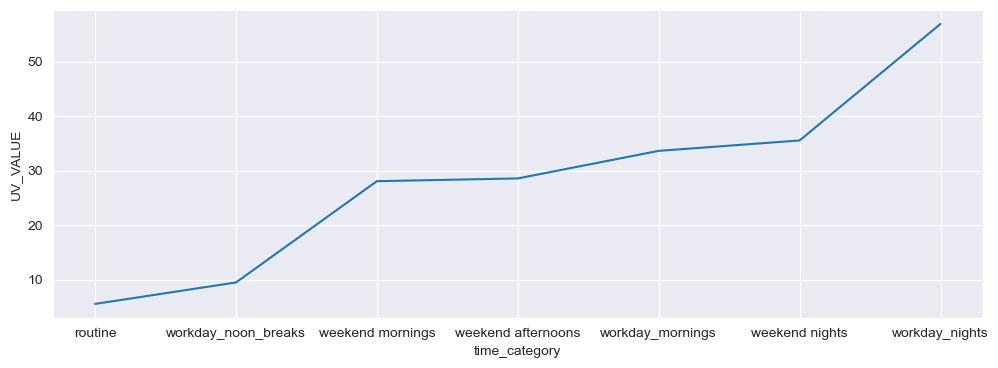

In [59]:
time_UV = time_UV.groupby('time_category').mean()
time_UV = time_UV.sort_values('UV_VALUE')
time_UV
plt.figure(figsize=(12,4))
sns.lineplot(x='time_category', y='UV_VALUE', data=time_UV)
plt.show()

In [60]:
time_UV = all_min[['UV_VALUE', 'date_time']]
time_UV['is_holiday'] = 0
time_UV.set_index('date_time', inplace=True)
time_UV['hour'] = time_UV.index.hour

In [62]:
for i, row in time_UV.iterrows():
    if pd.to_datetime(i).dayofweek not in (5, 6): # 0是星期一
        time_UV.loc[i, 'is_holiday'] = False
    else:
        time_UV.loc[i, 'is_holiday'] = True
    # time_UV.loc[i, 'is_holiday'] =

In [63]:
time_UV

,UV_VALUE,is_holiday,hour
date_time,,,
2019-10-04 08:00:00,0.0,False,8
2019-10-04 08:01:00,0.0,False,8
2019-10-04 08:02:00,0.0,False,8
2019-10-04 08:03:00,0.0,False,8
2019-10-04 08:04:00,0.0,False,8
...,...,...,...
2019-12-03 11:52:00,0.0,False,11
2019-12-03 11:53:00,0.0,False,11
2019-12-03 11:54:00,0.0,False,11


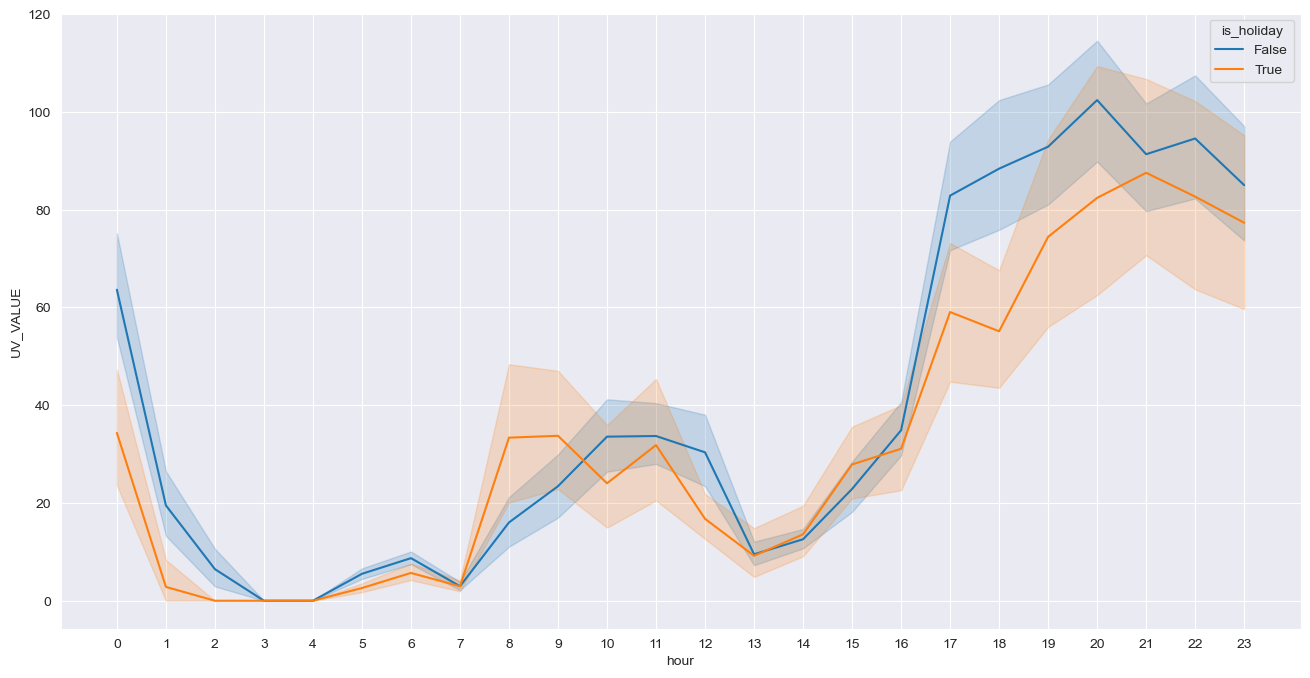

In [64]:
# time_UV[time_UV.eq(False).any(1)]
plt.figure(figsize=(16,8))
sns.lineplot(x='hour', y='UV_VALUE', data=time_UV, hue='is_holiday')
plt.xticks(list(range(24)))
plt.show()

In [65]:
data = all_min[['date_time', 'WATCH_UCNT']]
data.fillna(0)
data = data.set_index('date_time')

### 3.3 季节时序分析（demo）

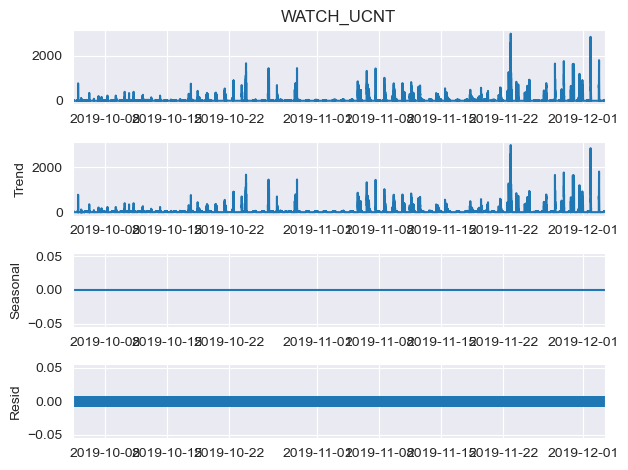

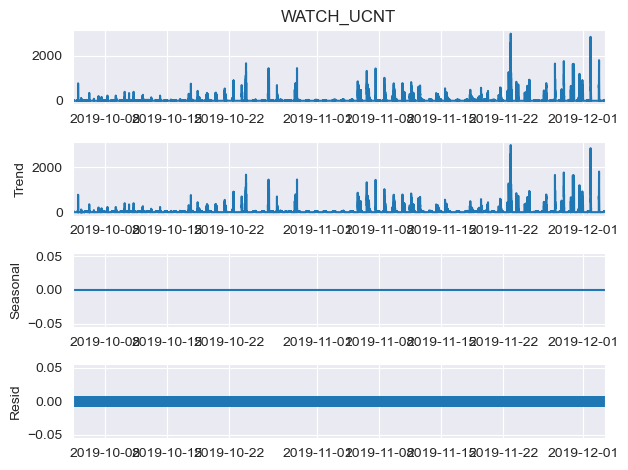

In [66]:
seasonal_WATCH_UCNT =seasonal_decompose(data['WATCH_UCNT'], period=1)
seasonal_WATCH_UCNT.plot()

## 4. 单特征LSTM预测（仅使用WATCH_UCNT）
### 4.1 创建测试集/训练集

In [320]:
scaler=MinMaxScaler(feature_range=(0,1))
df2=scaler.fit_transform(np.array(data).reshape(-1,1))

拆分测试集/训练集，这里其实可以使用sklearn.model_selection的train_test_split函数

In [321]:
training_size=int(len(data)*0.75)
test_size=len(data)-training_size
train_data,test_data=df2[0:training_size,:],df2[training_size:len(df2),:1]
training_size,test_size

(67488, 22496)

In [322]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [323]:
"""
LSTM 的 timestep 指的是在处理序列数据时，每个时间步携带的信息量。一般而言，LSTM 的每个时间步都是独立的，
可以使用前一个时间步的输出作为输入，并使用隐藏状态等数据来保留历史信息。每个时间步可以看作一个样本，整个序列可以看作多个时间步组成的数据集。
LSTM 的 timestep 大小的选择取决于数据集的性质和模型的目标。
如果 timestep 太小，可能不能捕捉到数据集的重要特征，并且难以保留历史信息，因此模型的性能会受到影响。
但是，如果 timestep 太大，模型的学习任务会变得更加困难，并且容易导致过拟合，因此模型的泛化能力会受到影响。

我选择100的心路历程：
数据复杂性：数据集中的模式需要多个时间步才能被完整捕捉。
模型的性能：通过对不同的 timestep 进行评估，找到性能最佳的一个。
模型的泛化能力：通过对不同的 timestep 进行评估，找到泛化能力最好的一个。
在该任务中，我尝试了10，100，200三种情况，最终选择100作为time_step
"""
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
print(X_test.shape)
print(y_test.shape)

(22395, 100)
(22395,)


In [342]:
# reshape 格式化输入, 将数据转化为3维数据, [number of samples, time_step I set before, features(WATCH_CNT)]
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

## 4.2 LSTM模型搭建、训练与评价 round-1：
Adam（Adaptive Moment Estimation）结合了另外两种优化算法（即随机梯度下降法（SGD）和 Adagrad）的优点，
并使用梯度的移动平均值和平方梯度的移动平均值来为每个权重提供自适应学习率，能够优化梯度不明显和噪声过多的情况。

AdaGrad (Adaptive Gradient Algorithm) 是一种自适应学习率优化算法，用于梯度下降法优化神经网络的参数。它通过不断调整每个参数的学习率来适应训练数据的复杂度，从而在训练的过程中加快收敛速度，同时避免因更新太快或太慢导致无法收敛的问题。

    优点：
    适用于处理稀疏数据：AdaGrad 对稀疏数据效果比较好，因为它能够根据稀疏数据的特点动态调整每个参数的学习率，使得其能够更快的收敛。
    能够更好的避免陷入局部最小值：由于 AdaGrad 对学习率进行了动态调整，因此能够更好的避免陷入局部最小值。

    可以用在：
    神经网络的参数优化：AdaGrad 通常用于优化神经网络的参数，在训练神经网络时通常可以加快收敛速度，并且提高模型的准确性。
    其他机器学习任务：除了用于神经网络的参数优化，AdaGrad 也可以用于其他机器学习任务，比如说支持向量机等算法的优化。

In [274]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1)) # 对于预测人数的回归问题，一般选择使用线性激活函数（默认参数）
model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 100, 50)           10400     
                                                                 
 lstm_28 (LSTM)              (None, 100, 50)           20200     
                                                                 
 lstm_29 (LSTM)              (None, 50)                20200     
                                                                 
 dense_8 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


如果 batch_size=1，那么模型每次只使用一个样本进行训练，这种方法称为随机梯度下降(SGD)；
如果 batch_size=64，那么模型每次使用64个样本进行训练，这种方法称为批量梯度下降(BGD)。
通常情况下，BGD能够较快的收敛，但是需要更多的内存；SGD则相反，训练慢一些，但是需要更少的内存。

In [275]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=30,batch_size=32,verbose=1)

Epoch 1/30
2106/2106 [==============================] - 177s 83ms/step - loss: 2.6716e-04 - val_loss: 0.0012
Epoch 2/30
2106/2106 [==============================] - 164s 78ms/step - loss: 2.3938e-04 - val_loss: 0.0014
Epoch 3/30
2106/2106 [==============================] - 168s 80ms/step - loss: 2.3017e-04 - val_loss: 0.0013
Epoch 4/30
2106/2106 [==============================] - 163s 77ms/step - loss: 2.2916e-04 - val_loss: 0.0012
Epoch 5/30
2106/2106 [==============================] - 167s 80ms/step - loss: 2.2606e-04 - val_loss: 0.0012
Epoch 6/30
2106/2106 [==============================] - 163s 77ms/step - loss: 2.2346e-04 - val_loss: 0.0011
Epoch 7/30
2106/2106 [==============================] - 167s 79ms/step - loss: 2.2320e-04 - val_loss: 0.0013
Epoch 8/30
2106/2106 [==============================] - 167s 79ms/step - loss: 2.2174e-04 - val_loss: 0.0011
Epoch 9/30
2106/2106 [==============================] - 163s 77ms/step - loss: 2.1585e-04 - val_loss: 0.0013
Epoch 10/30
2106/21

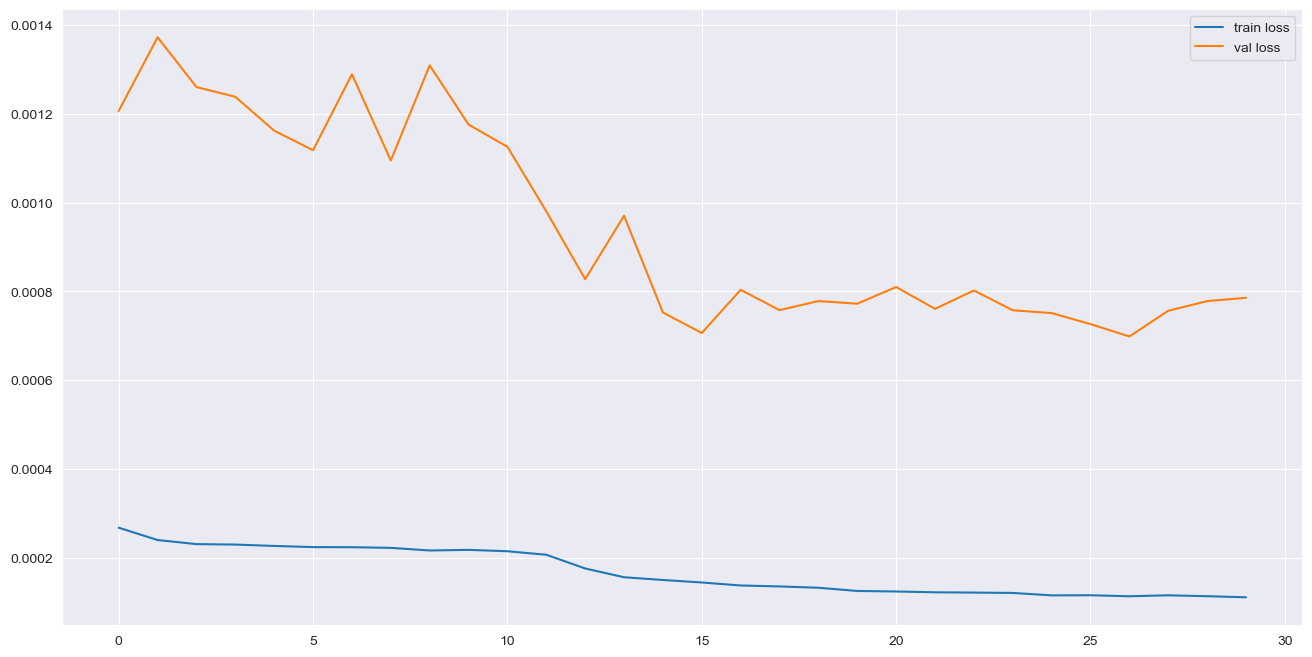

In [276]:
plt.figure(figsize=(16,8))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend(loc='best')
plt.show()

肉眼观察模型效果：
训练集loss减小，但验证集loss没有变化,这种情况通常是出现了过拟合，
说明模型在训练集上表现很好，但是对新数据的泛化能力不强。
可以通过采取正则化技巧，例如dropout或者L2正则化来解决过拟合问题。

## 4.3 LSTM模型搭建、训练于评价 round-2：
正则化方法选择的思路:
Dropout 是一种神经网络正则化技术，其原理是在训练过程中随机删除网络中的部分神经元，从而防止模型的过拟合。Dropout 对于简单的模型效果很好，但对于复杂的模型可能不够有效。
L2 正则化是一种惩罚系数矩阵的平方和，从而防止模型过拟合。L2 正则化通常比 Dropout 好，但其实现较复杂。
(失效！)在业务上，我认为使用Dropout会损失很多信息，相对于Dropout，L2通过L2引入惩罚系数的方式也许更好！

通过调整激活函数，避免过拟合现象的思路：
在LSTM层：
tanh（双曲正切函数）和线性激活函数比较常见，tanh其输出在-1到1之间，并且具有对称性和单调性，使其适合作为循环单元内部状态的激活函数。
线性激活函数是一种不改变输入值的激活函数，其可以通过linear指定，它具有简单性和稳定性，但在网络中不会产生额外的非线性效果。
在这里，我尝试了使用tanh作为新的激活函数，因为实时数据的变化不是简单线性关系。

在Dense全连接层：
最开始我的想法是这样的：
ReLU是简单快速的激活函数，对于大多数数据集都是一个很好的选择。然而，在数据中有较多的0值时，模型可能会发生梯度消失的问题，从而影响模型的性能。
LeakyReLU是ReLU的一种变体，具有较小的负斜率，从而防止梯度消失的问题。在处理具有0值的数据时，LeakyReLU可能更加有效。
ELU是Exponential Linear Unit的缩写，与LeakyReLU相似，具有负斜率。在处理具有0值的数据时，ELU可能更加有效，因为它的负斜率逐渐增大，直到达到极限值。因此，LeakyReLU和ELU的差别在于其如何处理输入的负值。LeakyReLU通过将负值乘以一个较小的负斜率来处理，而ELU则通过使用负数的指数处理负值来处理负值。因此，在某些情况下，ELU可能比LeakyReLU更有效，因为它在0处具有负平均值。
在这里，我先尝试了使用relu，但是也出现了训练集loss下降但验证集loss不变的情况，遂改用ELU。

*但是我发现效果很差，突然想到我的输入数据全部>=0，而ReLU在这种情况下可能会出现'ReLU Dying'的情况，即Relu激活函数中有一些神经元永远不会被激活，将所有输入设置为零。ELU也可能出现这种情况（虽然我的模型层数并不多...）于是我决定取消使用ELU，看一下效果。*

In [298]:
model=Sequential()
model.add(LSTM(64,return_sequences=True,input_shape=(100,1), activation='tanh'))
# 一般来说，可以从小到大不断调整 Dropout 参数，并观察训练误差和验证误差，选择一个使误差最小的值。另外，也可以通过交叉验证来选择 Dropout 参数。但是由于算力原因，我难以进行交叉验证择优选择参数，故使用他人经验选择0.5作为参数值
model.add(LSTM(64,return_sequences=True))
model.add(LSTM(32,return_sequences=False))
# 对于第一层和第二层，输出的序列作为下一层LSTM的输入，所以设置return_sequences为True。而对于最后一层，因为Dense层需要的是一个二维的数组作为输入，而不是一个三维的数组，如果还是设置为True，那么你需要对数据进行额外的预处理才能让数据适配到Dense层中，因此将return_sequences设置为False
model.add(Dense(1))
# 这里我一开始把L2正则化加在了LSTM层，效果很差：
# 正则化可以加在任意层，但是一般来说，通常在全连接层（Dense）上加L2正则化，以减小过拟合。
model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_51 (LSTM)              (None, 100, 64)           16896     
                                                                 
 lstm_52 (LSTM)              (None, 100, 64)           33024     
                                                                 
 lstm_53 (LSTM)              (None, 32)                12416     
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 62,369
Trainable params: 62,369
Non-trainable params: 0
_________________________________________________________________


In [299]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=30,batch_size=32,verbose=1)

Epoch 1/30
2106/2106 [==============================] - 177s 83ms/step - loss: 2.5975e-04 - val_loss: 0.0014
Epoch 2/30
2106/2106 [==============================] - 174s 83ms/step - loss: 2.3765e-04 - val_loss: 0.0013
Epoch 3/30
2106/2106 [==============================] - 174s 83ms/step - loss: 2.3359e-04 - val_loss: 0.0013
Epoch 4/30
2106/2106 [==============================] - 178s 84ms/step - loss: 2.2729e-04 - val_loss: 0.0012
Epoch 5/30
2106/2106 [==============================] - 175s 83ms/step - loss: 2.2553e-04 - val_loss: 0.0013
Epoch 6/30
2106/2106 [==============================] - 195s 93ms/step - loss: 2.2208e-04 - val_loss: 0.0011
Epoch 7/30
2106/2106 [==============================] - 197s 93ms/step - loss: 2.2159e-04 - val_loss: 0.0011
Epoch 8/30
2106/2106 [==============================] - 180s 85ms/step - loss: 2.1975e-04 - val_loss: 0.0013
Epoch 9/30
2106/2106 [==============================] - 178s 84ms/step - loss: 2.1941e-04 - val_loss: 0.0012
Epoch 10/30
2106/21

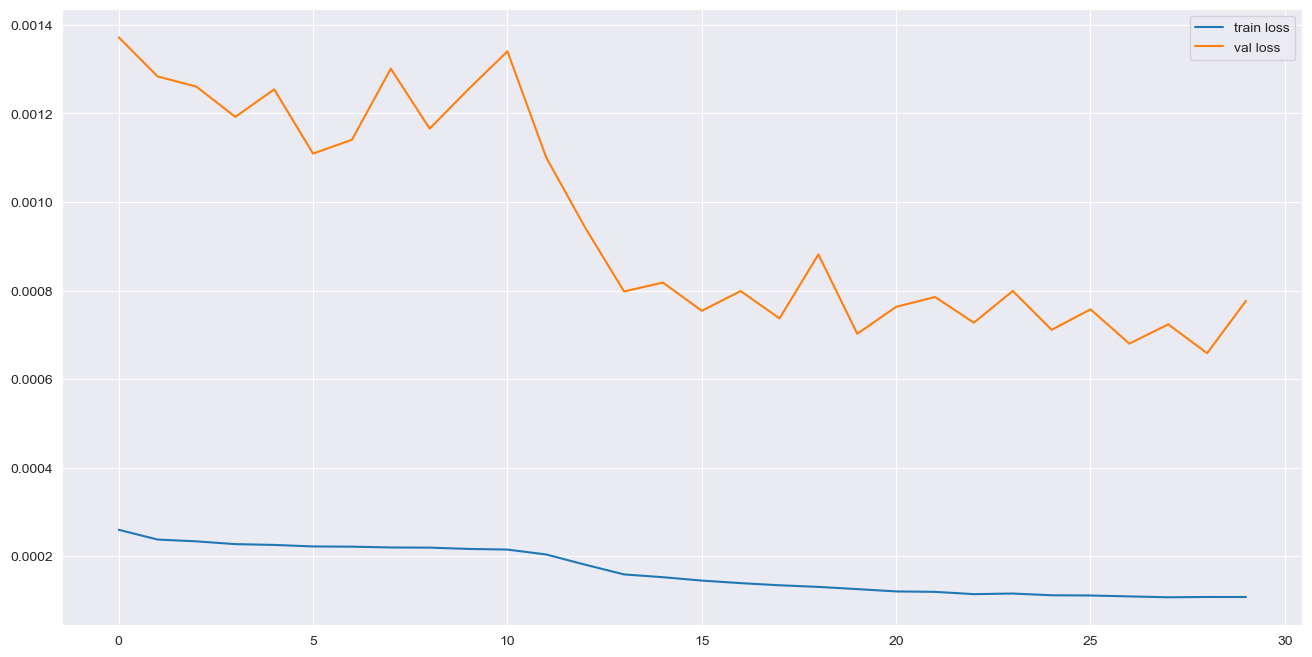

In [329]:
plt.figure(figsize=(16,8))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend(loc='best')
plt.show()

In [348]:
train_predict=model.predict(X_train)


2106/2106 [==============================] - 51s 24ms/step


In [359]:
test_predict=model.predict(X_test)

700/700 [==============================] - 19s 27ms/step


In [360]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [362]:
test_predict

array([[33.163506],
       [24.718239],
       [24.489466],
       ...,
       [18.731014],
       [22.109192],
       [16.247318]], dtype=float32)

In [366]:
yt=scaler.inverse_transform(y_test.reshape(-1, 1))
dt=pd.DataFrame(yt)
dt['Real']=yt
dt['Prediction']= test_predict.round().astype(int)
dt=dt.drop(columns=[0])
dt['Difference']=abs(dt['Real']-dt['Prediction'])
dt['Diff_Ratio'] = dt['Difference'] / dt['Real']
dt.tail()

,Real,Prediction,Difference,Diff_Ratio
22390,9.0,16,7.0,0.777778
22391,13.0,14,1.0,0.076923
22392,16.0,19,3.0,0.187500
22393,9.0,22,13.0,1.444444
22394,15.0,16,1.0,0.066667


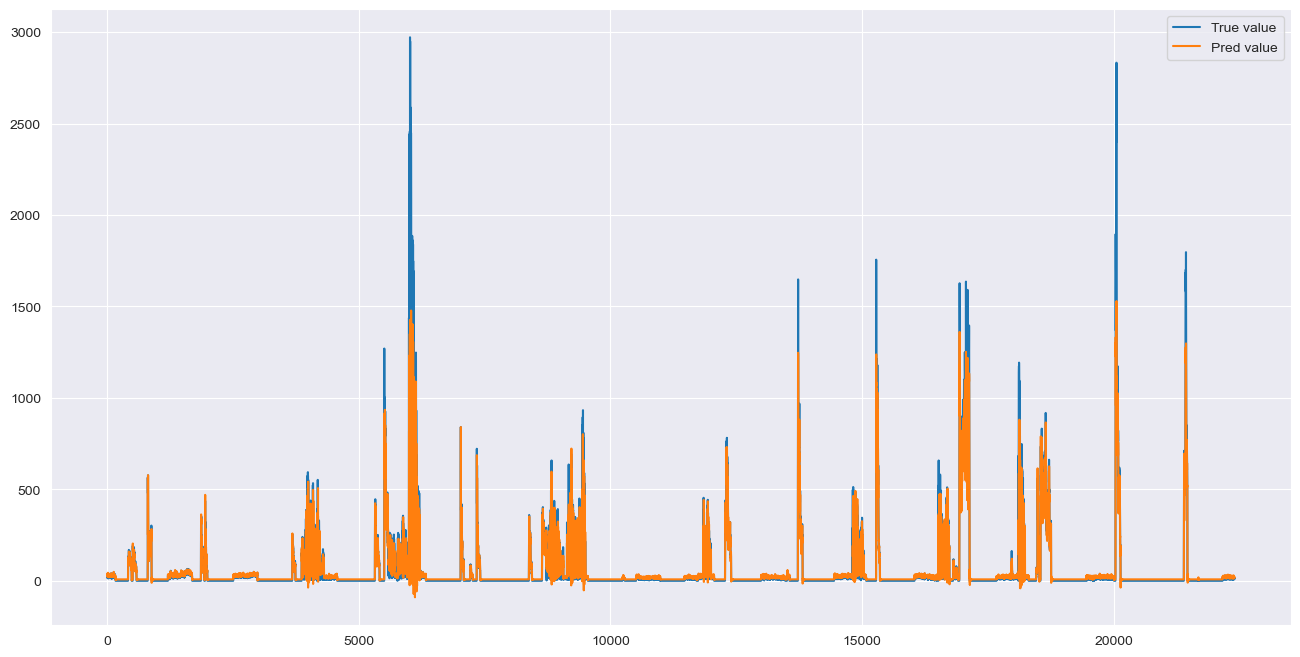

In [367]:
# 绘制 预测与真值结果
plt.figure(figsize=(16,8))
plt.plot(dt['Real'][:], label="True value")
plt.plot(dt['Prediction'][:], label="Pred value")
plt.legend(loc='best')  # loc控制图例在图中的位置，一般 best 就够了
plt.show()

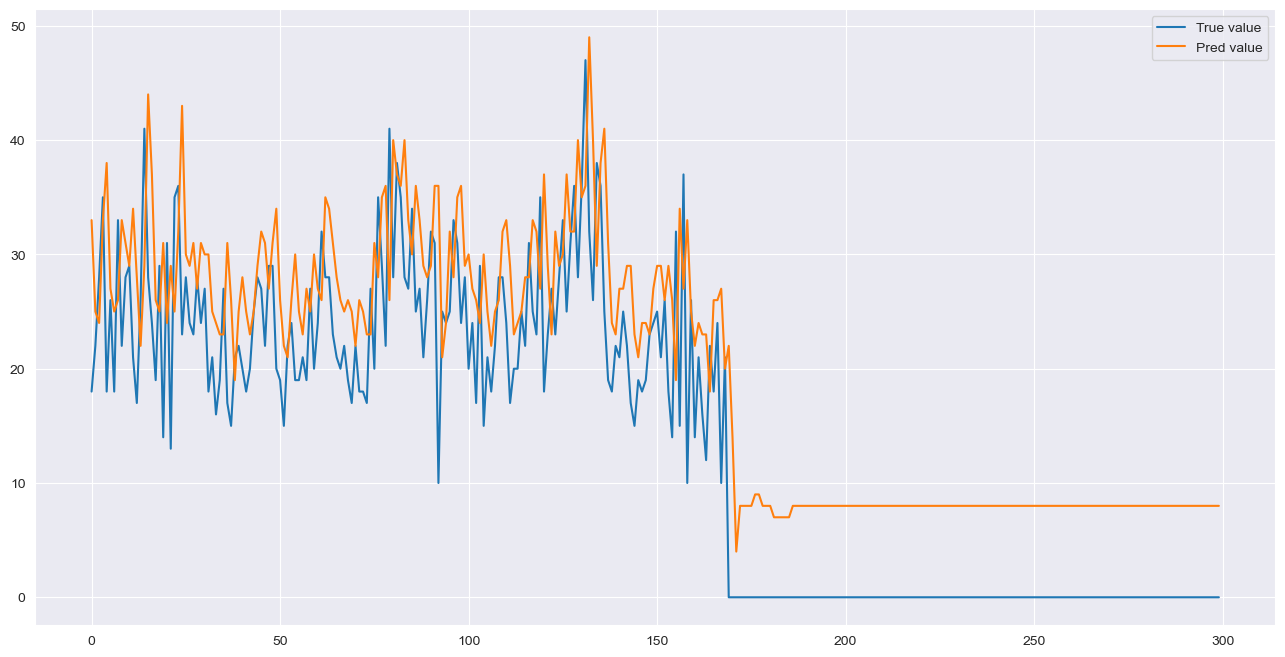

In [368]:
plt.figure(figsize=(16,8))
plt.plot(dt['Real'][0:300], label="True value")
plt.plot(dt['Prediction'][0:300], label="Pred value")
plt.legend(loc='best')
plt.show()

In [369]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print("Train Score: ", trainScore)
testScore = model.evaluate(X_test, y_test, verbose=0)
print("Test Score: ", testScore)

Train Score:  0.00010879724140977487
Test Score:  0.0007766927010379732


计算R2：
    r2, coefficient of determination, 是一种用于评估回归模型拟合度的统计度量。它衡量模型根据输入特征的变化解释目标变量的变化的能力。
    r2的值在0和1之间，接近1表示良好的拟合，接近0表示不佳的拟合。负的r2意味着模型不是很好的拟合，实际上比仅使用目标变量的平均值作为预测更劣。
    感觉只能用来横向比较hh
    所以我打算一会和多变量LSTM比较一下子！

In [127]:
score = r2_score(yt, test_predict)
score

0.7557543280558318

计算RMSE

In [133]:
### Calculate RMSE performance metrics
print("RMSE for Training data: ",math.sqrt(mean_squared_error(y_train,train_predict)))
print("RMSE for Test data: ",math.sqrt(mean_squared_error(yt,test_predict)))

RMSE for Training data:  196132.57154136949
RMSE for Test data:  1.6361437876652203


计算平均偏差率

In [35]:
np.mean(np.abs((yt - test_predict) / yt)) * 100

inf

* todo: 看上去拟合情况还不错，但是对于极值的预测比较困难，解决方法待查

### 4.4 完成数据预测任务

提取和预处理 predict.csv 数据

In [571]:
pred_data = pd.read_csv('predict.csv')
df1 = pred_data['natural_flow_trend_index'].apply(eval).apply(pd.Series)
df2 = pred_data['pay_flow_trend_index'].apply(eval).apply(pd.Series)
pred_data = pred_data.join(df1).join(df2).drop(['natural_flow_trend_index', 'pay_flow_trend_index'], axis = 1)
pred_data.date_time = pred_data.date_time.astype('datetime64[ns]')
pred_data.fillna(0)
pred_data.drop('Unnamed: 0', axis=1)

,UV_VALUE,COMMENT_CNT,date_time,INCR_FANS_CNT,LEAVE_UCNT,FANS_CLUB_UCNT,PAY_ORDER_GMV,ONLINE_USER_CNT,WATCH_UCNT,PAY_CNT,...,头条西瓜,活动页,全部自然流量,关注,千川PC版,其他广告,千川品牌广告,全部付费流量,品牌广告,小店随心推
0,0.0,0,2019-12-02 08:12:00,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,9,2019-12-02 08:13:00,0.0,10.0,0.0,0.0,11,19.0,0.0,...,0,0,7,4,0,0,0,0,0,0
2,0.0,9,2019-12-02 08:14:00,0.0,22.0,0.0,0.0,15,23.0,0.0,...,0,0,14,4,0,0,0,0,0,0
3,0.0,7,2019-12-02 08:15:00,0.0,7.0,0.0,0.0,14,8.0,0.0,...,0,0,14,3,0,0,0,0,0,0
4,0.0,15,2019-12-02 08:16:00,0.0,12.0,0.0,0.0,17,14.0,0.0,...,0,0,10,6,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,0.0,2,2019-12-02 23:44:00,0.0,13.0,0.0,0.0,26,14.0,0.0,...,0,0,11,6,0,0,0,0,0,0
692,0.0,4,2019-12-02 23:45:00,0.0,29.0,0.0,0.0,26,26.0,0.0,...,0,0,22,14,0,0,0,0,0,0
693,0.0,0,2019-12-02 23:46:00,0.0,14.0,0.0,0.0,25,16.0,0.0,...,0,0,14,7,0,0,0,0,0,0
694,0.0,0,2019-12-02 23:47:00,0.0,17.0,0.0,0.0,27,22.0,0.0,...,0,1,25,17,0,0,0,0,0,0


In [572]:
# 提取单变量WATCH_UCNT并标准化
pred_data = pred_data[['WATCH_UCNT']]
zeros = pd.Series([0] * 10)
pred_data = pd.concat([pred_data['WATCH_UCNT'], zeros], axis=0)

In [574]:
pred_data = pd.DataFrame(np.array(pred_data))
pred_data = scaler.fit_transform(pred_data)
# minmaxscaler.transform 和 minmaxscaler.fit_transform 的区别是：
# minmaxscaler.fit_transform: 先找到数据的最大值和最小值，然后计算所有数据的缩放值并进行缩放，同时返回缩放后的数据。
# minmaxscaler.transform: 已经计算出了数据的最大值和最小值，然后直接使用已有的最大值和最小值对数据进行缩放，并返回缩放后的数据。
# 所以，如果没有计算过数据的最大值和最小值，那么必须使用 minmaxscaler.fit_transform。如果已经计算过，则可以直接使用 minmaxscaler.transform。

In [575]:
pred_data = pred_data.astype(float)

In [576]:
pred_data = pred_data.reshape(len(pred_data), 1, 1)
pred_data.shape

(706, 1, 1)

In [578]:
# look_back=100
# trainPredictPlot = np.empty_like(df2)
# trainPredictPlot[:, :] = np.nan
# trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
#
# testPredictPlot = np.empty_like(df2)
# testPredictPlot[:, :] = np.nan
# testPredictPlot[len(train_predict)+(look_back*2)+1:len(df2)-1, :] = test_predict
#
# plt.plot(scaler.inverse_transform(df2))
# plt.plot(trainPredictPlot)
# plt.plot(testPredictPlot)
# plt.show()

In [579]:
x_input=pred_data[:696].reshape(1, -1)
x_input.shape

(1, 696)

In [580]:
x_input

array([[0.        , 0.37254902, 0.45098039, 0.15686275, 0.2745098 ,
        0.19607843, 0.25490196, 0.60784314, 0.43137255, 0.54901961,
        0.43137255, 0.43137255, 0.39215686, 0.45098039, 0.41176471,
        0.50980392, 0.47058824, 0.58823529, 0.2745098 , 0.2745098 ,
        0.37254902, 0.43137255, 0.43137255, 0.35294118, 0.23529412,
        0.2745098 , 0.43137255, 0.31372549, 0.41176471, 0.35294118,
        0.35294118, 0.31372549, 0.17647059, 0.37254902, 0.50980392,
        0.39215686, 0.39215686, 0.43137255, 0.25490196, 0.47058824,
        0.37254902, 0.39215686, 0.39215686, 0.25490196, 0.43137255,
        0.52941176, 0.43137255, 0.35294118, 0.19607843, 0.31372549,
        0.35294118, 0.37254902, 0.43137255, 0.47058824, 0.25490196,
        0.39215686, 0.23529412, 0.19607843, 0.33333333, 0.25490196,
        0.29411765, 0.31372549, 0.31372549, 0.29411765, 0.37254902,
        0.33333333, 0.35294118, 0.31372549, 0.35294118, 0.35294118,
        0.35294118, 0.25490196, 0.33333333, 0.29

In [581]:
temp_input=list(x_input)
temp_input

[array([0.        , 0.37254902, 0.45098039, 0.15686275, 0.2745098 ,
        0.19607843, 0.25490196, 0.60784314, 0.43137255, 0.54901961,
        0.43137255, 0.43137255, 0.39215686, 0.45098039, 0.41176471,
        0.50980392, 0.47058824, 0.58823529, 0.2745098 , 0.2745098 ,
        0.37254902, 0.43137255, 0.43137255, 0.35294118, 0.23529412,
        0.2745098 , 0.43137255, 0.31372549, 0.41176471, 0.35294118,
        0.35294118, 0.31372549, 0.17647059, 0.37254902, 0.50980392,
        0.39215686, 0.39215686, 0.43137255, 0.25490196, 0.47058824,
        0.37254902, 0.39215686, 0.39215686, 0.25490196, 0.43137255,
        0.52941176, 0.43137255, 0.35294118, 0.19607843, 0.31372549,
        0.35294118, 0.37254902, 0.43137255, 0.47058824, 0.25490196,
        0.39215686, 0.23529412, 0.19607843, 0.33333333, 0.25490196,
        0.29411765, 0.31372549, 0.31372549, 0.29411765, 0.37254902,
        0.33333333, 0.35294118, 0.31372549, 0.35294118, 0.35294118,
        0.35294118, 0.25490196, 0.33333333, 0.29

In [582]:
temp_input=temp_input[0].tolist()
temp_input

[0.0,
 0.37254901960784315,
 0.45098039215686275,
 0.1568627450980392,
 0.27450980392156865,
 0.19607843137254902,
 0.2549019607843137,
 0.6078431372549019,
 0.43137254901960786,
 0.5490196078431373,
 0.43137254901960786,
 0.43137254901960786,
 0.39215686274509803,
 0.45098039215686275,
 0.4117647058823529,
 0.5098039215686274,
 0.47058823529411764,
 0.5882352941176471,
 0.27450980392156865,
 0.27450980392156865,
 0.37254901960784315,
 0.43137254901960786,
 0.43137254901960786,
 0.3529411764705882,
 0.23529411764705882,
 0.27450980392156865,
 0.43137254901960786,
 0.3137254901960784,
 0.4117647058823529,
 0.3529411764705882,
 0.3529411764705882,
 0.3137254901960784,
 0.1764705882352941,
 0.37254901960784315,
 0.5098039215686274,
 0.39215686274509803,
 0.39215686274509803,
 0.43137254901960786,
 0.2549019607843137,
 0.47058823529411764,
 0.37254901960784315,
 0.39215686274509803,
 0.39215686274509803,
 0.2549019607843137,
 0.43137254901960786,
 0.5294117647058824,
 0.43137254901960786,


In [583]:
list.__len__(temp_input)

696

## *** 进行时间序列预测 ***

In [ ]:
# demonstrate prediction for next 10 minutes
from numpy import array

lst_output=[]
n_steps=695
i=0
while i < 10:

    if len(temp_input)>100:
        x_input=np.array(temp_input[1:]) # 从1开始，去掉第0位
        x_input = x_input.reshape(1,-1) # 改成列表示
        x_input = x_input.reshape((1, n_steps, 1)) # 改成三维
        y_pred = model.predict(x_input, verbose=0) # 预测
        temp_input.extend(y_pred[0].tolist())
        y_predout = scaler.inverse_transform(pd.DataFrame(temp_input))
        print("{} minute's output {}".format(i + 1,y_predout[-1].astype(int)))
        temp_input = temp_input[1:]
        lst_output.extend(y_predout[-1].astype(int).tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        y_pred = model.predict(x_input, verbose=0)
        temp_input.extend(y_pred[0].tolist())
        y_predout = scaler.inverse_transform(pd.DataFrame(temp_input))
        print("{} minute's output {}".format(i + 1,y_predout[-1].astype(int)))
        # print(len(temp_input))
        lst_output.extend(y_predout[-1].astype(int).tolist())
        i = i + 1


# print(lst_output)

In [585]:
lst_output

[17, 14, 13, 11, 10, 8, 7, 7, 6, 5]

## 5. （补充，未进行预测任务）多特征LSTM预测（仅使用WATCH_UCNT）

In [589]:
data = all_min.set_index('date_time')
data.astype(np.float32)

,UV_VALUE,COMMENT_CNT,INCR_FANS_CNT,LEAVE_UCNT,FANS_CLUB_UCNT,PAY_ORDER_GMV,ONLINE_USER_CNT,WATCH_UCNT,PAY_CNT,PAY_UCNT,...,头条西瓜,活动页,全部自然流量,关注,千川PC版,其他广告,千川品牌广告,全部付费流量,品牌广告,小店随心推
date_time,,,,,,,,,,,,,,,,,,,,,
2019-10-04 08:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-10-04 08:01:00,0.0,5.0,0.0,3.0,0.0,0.0,7.0,9.0,0.0,0.0,...,0.0,0.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-10-04 08:02:00,0.0,2.0,2.0,17.0,1.0,0.0,10.0,20.0,0.0,0.0,...,0.0,0.0,9.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-10-04 08:03:00,0.0,2.0,0.0,20.0,0.0,0.0,12.0,19.0,0.0,0.0,...,1.0,0.0,17.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-10-04 08:04:00,0.0,6.0,0.0,9.0,0.0,0.0,14.0,16.0,0.0,0.0,...,0.0,0.0,13.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-03 11:52:00,0.0,2.0,0.0,8.0,0.0,0.0,51.0,13.0,0.0,0.0,...,0.0,0.0,6.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-03 11:53:00,0.0,5.0,0.0,14.0,1.0,0.0,56.0,16.0,0.0,0.0,...,0.0,0.0,18.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-03 11:54:00,0.0,2.0,0.0,26.0,0.0,0.0,57.0,9.0,0.0,0.0,...,0.0,0.0,18.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0


In [590]:
data.shape

(89984, 27)

In [591]:
# 数据归一化
for col in data.columns:
    scaler = MinMaxScaler()
    data[col] = scaler.fit_transform(data[col].values.reshape(-1,1))

In [592]:
# 特征数据集
X = data
print(X.shape)
y = data['WATCH_UCNT']
print(y.shape)

(89984, 27)
(89984,)


In [593]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False, random_state=666)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((67488, 27), (22496, 27), (67488,), (22496,))

In [595]:
def create_dataset(X, y, seq_len=100):
    features = []
    targets = []

    for i in range(0, len(X) - seq_len, 1):
        data = X.iloc[i:i+seq_len] # train序列数据
        label = y.iloc[i+seq_len] # label标签数据
        features.append(data)
        targets.append(label)

    return np.array(features).astype(np.float32), np.array(targets).astype(np.float32)

# train dataset
train_dataset, train_labels = create_dataset(X_train, y_train, seq_len=30)
# test dataset
test_dataset, test_labels = create_dataset(X_test, y_test, seq_len=30)

In [596]:
# 尝试换个建模方法～
def create_batch_dataset(X, y, train=True, buffer_size=1000, batch_size=64):
    batch_data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y))) # 数据封装，tensor类型
    if train: # 训练集
        # return batch_data.cache().shuffle(buffer_size).batch(batch_size)
        return batch_data.cache().batch(batch_size)
    else: # 测试集
        return batch_data.batch(batch_size)
# 训练集数据
train_batch_dataset = create_batch_dataset(train_dataset, train_labels, train=True)
# 测试集数据
test_batch_dataset = create_batch_dataset(test_dataset, test_labels, train=False)

## 模型搭建

尽管多特征LSTM和单特征LSTM的数据体量和性质不一样，是的，MSE（均方误差）可以用来比较两个数据规模和参数数量不同的模型。
MSE反映了模型预测值与真实值之间的平均误差，与数据规模和参数数量无关，因此可以用来比较不同模型的表现。
由于我的训练结果最终趋向于过拟合，MSE表现也比不上上一个模型，因此弃用该模型进行业务预测。

In [597]:
model = Sequential([
    layers.LSTM(units=256, input_shape=train_dataset.shape[-2:], return_sequences=True, activation='tanh'), # train_dataset.shape[-2:0]代表从倒数第二维到最后一维（train_dataset的第一维是空的）
    layers.Dropout(0.5),
    layers.LSTM(units=128, return_sequences=True),
    layers.Dropout(0.3),
    layers.LSTM(units=128, return_sequences=True),
    layers.LSTM(units=64),
    layers.Dense(1)
])

# 模型编译
model.compile(optimizer='adam',loss='mean_squared_error')

checkpoint_file = "best_model.hdf5"

checkpoint_callback = ModelCheckpoint(filepath=checkpoint_file,
                                      monitor='loss',
                                      mode='min',
                                      save_best_only=True,
                                      save_weights_only=True)
# 模型训练
history = model.fit(train_batch_dataset,
                    epochs=30,
                    validation_data=test_batch_dataset,
                    callbacks=[checkpoint_callback])
# 显示训练结果
plt.figure(figsize=(16,8))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend(loc='best')
plt.show()

Epoch 1/30
1055/1055 [==============================] - 184s 171ms/step - loss: 5.6782e-04 - val_loss: 0.0029
Epoch 2/30
1055/1055 [==============================] - 178s 168ms/step - loss: 4.5449e-04 - val_loss: 0.0031
Epoch 3/30
1055/1055 [==============================] - 179s 170ms/step - loss: 3.4497e-04 - val_loss: 0.0020
Epoch 4/30
1055/1055 [==============================] - 179s 170ms/step - loss: 3.1510e-04 - val_loss: 0.0020
Epoch 5/30
1055/1055 [==============================] - 180s 170ms/step - loss: 2.9844e-04 - val_loss: 0.0017
Epoch 6/30
1055/1055 [==============================] - 217s 206ms/step - loss: 3.5380e-04 - val_loss: 0.0021
Epoch 7/30
1055/1055 [==============================] - 209s 198ms/step - loss: 3.0183e-04 - val_loss: 0.0017
Epoch 8/30
1055/1055 [==============================] - 219s 207ms/step - loss: 3.0786e-04 - val_loss: 0.0023
Epoch 9/30
1055/1055 [==============================] - 229s 217ms/step - loss: 3.7029e-04 - val_loss: 0.0023
Epoch 10/3

KeyboardInterrupt: 

## 模型表现分析

In [76]:
test_preds = model.predict(test_dataset, verbose=1)

NameError: name 'test_dataset' is not defined

In [227]:
score = r2_score(test_labels, test_preds)
score

0.7268333420732938

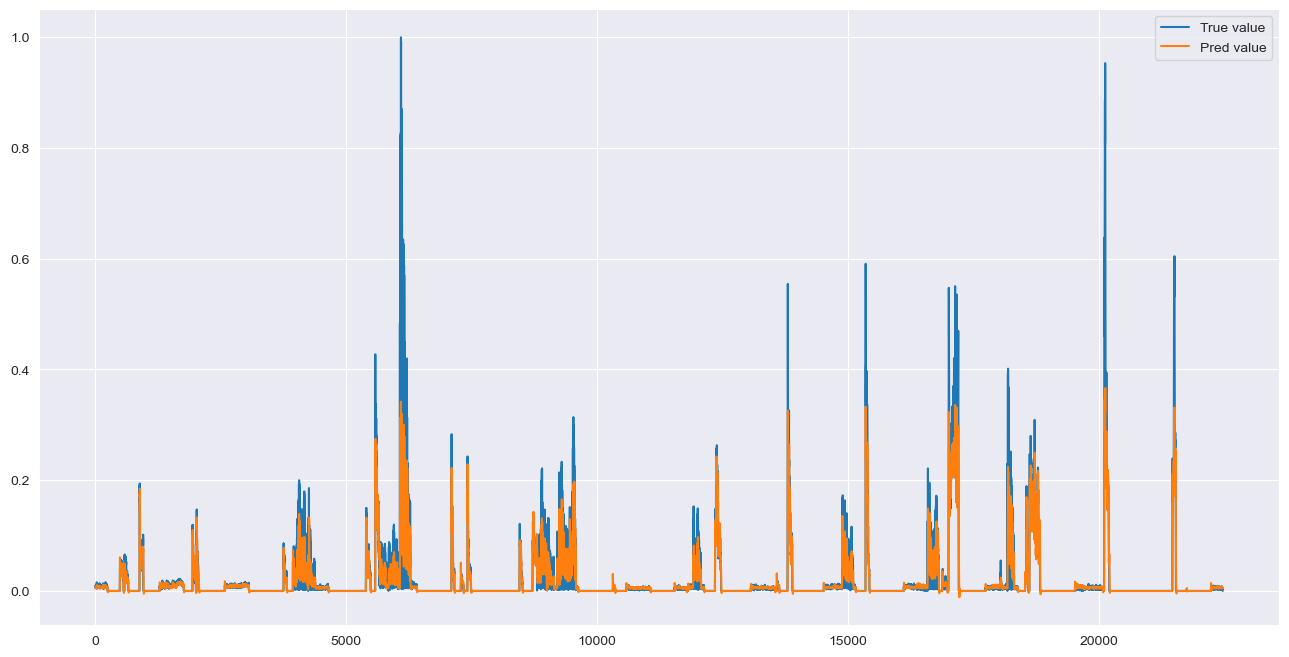

In [231]:
# 绘制 预测与真值结果

plt.figure(figsize=(16,8))
plt.plot(test_labels[:], label="True value")
plt.plot(test_preds[:], label="Pred value")
plt.legend(loc='best')
plt.show()

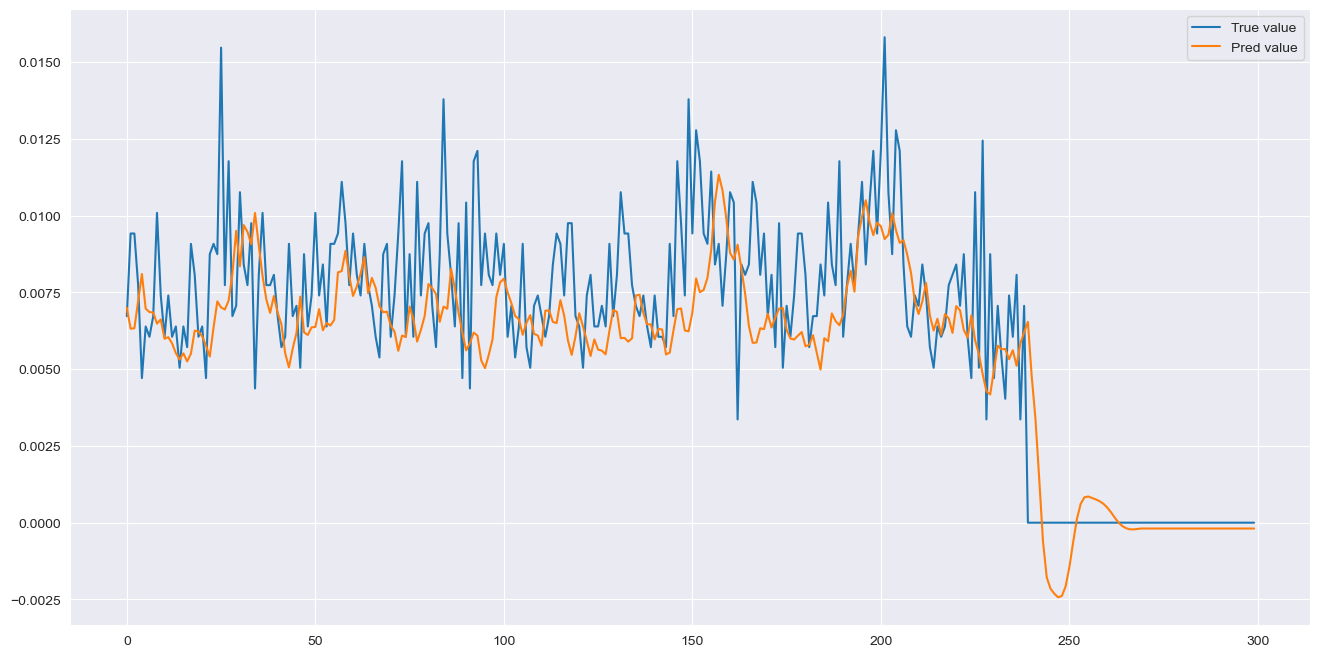

In [233]:
plt.figure(figsize=(16,8))
plt.plot(test_labels[0:300], label="True value")
plt.plot(test_preds[0:300], label="Pred value")
plt.legend(loc='best')
plt.show()